# Libraries & Custom functions

### Imports

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import DataLoader
from tqdm import tqdm

# Ignore UserWarning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [21]:
############################################################### Functions for Part 1 b) ###############################################################

def BCE_Loss(y_true, y_hat):
    if y_true == y_hat:
        return torch.tensor(0.)

    return -1 * (y_true * torch.log(y_hat) + (1 - y_true) * torch.log(1 - y_hat))


def ForwardPass(X, W, b = 0):

    z1 = torch.matmul(X, W[0].T) + b
    a1 = F.relu(z1)

    z2 = torch.matmul(a1, W[1].T) + b
    a2 = F.leaky_relu(z2, negative_slope = 0.01)

    z3 = torch.matmul(a2, W[2].T) + b
    a3 = F.sigmoid(z3)

    return a3, a2, a1


def BackwardPass(X, a1, a2, a3, y_true, W):

    # Partial derivative of the loss function with respect to the prediction
    dL_da3 = -1 * (y_true / a3 - (1 - y_true) / (1 - a3)) if y_true != a3 else torch.tensor([0.])
    # Partial derivative of the loss function with respect to z3, using the sigmoid derivative
    dL_dz3 = dL_da3 * (a3 * (1 - a3))
    # Partial derivative of the loss function with respect to the weights of the connections between the second hidden layer and the output layer
    dL_dW3 = torch.matmul(dL_dz3.T, a2)

    # Partial derivative of the loss function with respect to the activation values from the second hidden layer
    dL_da2 = torch.matmul(dL_dz3, W[2])
    # Partial derivative of the loss function with respect to z2, using the Leaky ReLU derivative
    dL_dz2 = torch.where(a2 >= 0, dL_da2, 0.01 * dL_da2)
    # Partial derivative of the loss function with respect to the weights of the connections between the first and second hidden layers
    dL_dW2 = torch.matmul(dL_dz2.T, a1)

    # Partial derivative of the loss function with respect to the activation values from the first hidden layer
    dL_da1 = torch.matmul(dL_dz2, W[1])
    # Partial derivative of the loss function with respect to z2, using the ReLU derivative
    dL_dz1 = torch.where(a1 >= 0, dL_da1, 0.0 * dL_da1)
    # Partial derivative of the loss function with respect to the weights of the connections between the input layer and the first hidden layers
    dL_dW1 = torch.matmul(dL_dz1.T, X)

    return dL_dW1, dL_dW2, dL_dW3


def StochasticGradientDescent(dL_dW1, dL_dW2, dL_dW3, W, lr):
    # Update weights using SGD
    W[0] -= lr * dL_dW1
    W[1] -= lr * dL_dW2
    W[2] -= lr * dL_dW3

    return W


############################################################### Functions for Part 1 c) and d) ###############################################################

# Define a function to display a batch of images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Fix the missing closing parenthesis
    plt.show()


def set_device():
    if torch.cuda.is_available():
        device = torch.device('cuda')

    elif torch.backends.mps.is_available():
        device = torch.device('mps')

    else:
        device = torch.device('cpu')
    print('Device:', device)

    return device


class NeuralNetwork_Exercise1_c(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(784, 256)  # Input size for MNIST is 28x28=784
        self.fc2 = torch.nn.Linear(256, 128)
        self.fc3 = torch.nn.Linear(128, 10)   # 10 output classes for Fashion-MNIST
        self.relu = torch.nn.ReLU()
        self.leaky_relu = torch.nn.LeakyReLU(0.01)

    def forward(self, x):
        x = x.view(-1, 784)  # Flatten the input
        x = self.relu(self.fc1(x))
        x = self.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Define a more complex neural network
class NeuralNetwork_Exercise1_d(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.input_layer = torch.nn.Linear(784, 256)
        self.fc_128_256 = torch.nn.Linear(128, 256)
        self.fc_256_512 = torch.nn.Linear(256, 512)
        self.fc_128_128 = torch.nn.Linear(128, 128)
        self.fc_256_256 = torch.nn.Linear(256, 256)
        self.fc_512_512 = torch.nn.Linear(512, 512)
        self.fc_512_1024 = torch.nn.Linear(512, 1024)
        self.fc_1024_1024 = torch.nn.Linear(1024, 1024)
        self.fc_1024_2048 = torch.nn.Linear(1024, 2048)
        self.fc_2048_1024 = torch.nn.Linear(2048, 1024)
        self.fc_2048_2048 = torch.nn.Linear(2048, 2048)
        self.fc_1024_512 = torch.nn.Linear(1024, 512)
        self.fc_512_256 = torch.nn.Linear(512, 256)
        self.fc_256_128 = torch.nn.Linear(256, 128)
        self.fc_128_64 = torch.nn.Linear(128, 64)
        self.output_layer = torch.nn.Linear(128, 10)
        self.leaky_relu = torch.nn.LeakyReLU(0.01)
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.dropout_10 = torch.nn.Dropout(0.1)
        self.dropout_20 = torch.nn.Dropout(0.2)
        self.dropout_30 = torch.nn.Dropout(0.3)
        self.dropout_40 = torch.nn.Dropout(0.4)
        self.dropout_50 = torch.nn.Dropout(0.5)
        self.batch_norm2048 = torch.nn.BatchNorm1d(2048)
        self.batch_norm1024 = torch.nn.BatchNorm1d(1024)
        self.batch_norm512 = torch.nn.BatchNorm1d(512)
        self.batch_norm256 = torch.nn.BatchNorm1d(256)
        self.batch_norm128 = torch.nn.BatchNorm1d(128)
        self.batch_norm64 = torch.nn.BatchNorm1d(64)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.relu(self.batch_norm256(self.input_layer(x)))
        x = self.dropout_50(x)
        x = self.relu(self.batch_norm128(self.fc_256_128(x)))
        x = self.output_layer(x)
        return x


def train(model, train_loader, optimizer, scheduler, loss_func, epochs, device, **kwargs):

    num_epochs = kwargs.get('num_epochs', epochs)
    loss_fn = kwargs.get('loss_fn', loss_func)
    device = kwargs.get('device', device)

    train_loss_hist, train_acc_hist = [], []
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')

        print('Training phase...')
        model.train()
        train_loss = 0.
        total = 0.
        correct = 0.
        pbar = tqdm(enumerate(train_loader), total = len(train_loader))

        for batch_idx, (data, target) in pbar:
            data = data.to(device)
            target = target.to(device)
            model.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            pbar.set_description(f'Loss = {loss:.4f}  |  Accuracy = {100 * correct / total:.2f}% | Batch ID = {batch_idx + 1} ')

        print(f"Learning Rate = {optimizer.param_groups[0]['lr']}")
        scheduler.step()

        train_loss /= len(train_loader)
        train_accuracy = 100 * correct / total
        print(f'Training Cross-Entropy Loss = {train_loss:.4f}')
        print(f'Training Accuracy = {train_accuracy:.2f}%')
        print()
        train_loss_hist.append(train_loss)
        train_acc_hist.append(train_accuracy)

    print(f"Cross-Entropy on training set:  {train_loss_hist[-1]:.4f}")
    print(f"Accuracy on training set:       {train_acc_hist[-1]:.2f}%")

    return train_loss_hist, train_acc_hist


def test(model, test_loader, loss_func, device):

    model.eval()

    correct = 0
    total = 0
    test_loss = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            test_loss += loss_func(outputs, labels).item()

    test_loss /= len(test_loader)
    test_acc = 100 * correct / total

    print(f"Cross-Entropy on test set: {test_loss:.4f}")
    print(f"Accuracy on test set: {test_acc:.2f}%")

    return test_loss, test_acc

# Exercise 1

### Exercise 1. (A)

**Backpropagation** and **gradient descent** are like a dynamic duo in training deep neural networks (DNNs).

**Backpropagation** is the process of updating the model's weights by calculating the gradient of the loss function with respect to the weights. It's all about figuring out how much each weight contributed to the error, layer by layer, starting from the output layer and working backward through the network. This info helps adjust the weights to minimize the error in future predictions.

Now, **gradient descent** is the optimization technique that works hand-in-hand with backpropagation. It's all about finding the minimum of the loss function. The gradient (derivative) of the loss with respect to the weights tells us the direction of the steepest increase. Gradient descent takes steps in the opposite direction to minimize the loss.

So, to sum it up, backpropagation fine-tunes the weights based on the error, and gradient descent guides this process by minimizing the error step by step. They team up to make our neural networks smarter!

#### References

 - https://www.analyticsvidhya.com/blog/2023/01/gradient-descent-vs-backpropagation-whats-the-difference/#:~:text=To%20put%20it%20plainly%2C%20gradient,gradient%20descent%20relies%20on%20backpropagation.

### Exercise 1. (B)

#### References
https://towardsdatascience.com/nothing-but-numpy-understanding-creating-binary-classification-neural-networks-with-e746423c8d5c

In [3]:
input_values = torch.tensor([[5., 4., 1., 3., 2.]])

y_true = torch.tensor([1.])

w1 = torch.tensor([[0.2, 0.2, 0.2, 0.2, 0.2],
                   [0.2, 0.2, 0.2, 0.2, 0.2],
                   [0.2, 0.2, 0.2, 0.2, 0.2]])

w2 = torch.tensor([[0.2, 0.2, 0.2],
                   [0.2, 0.2, 0.2]])

w3 = torch.tensor([[0.2, 0.2]])

W = list([w1, w2, w3])

In [4]:
a3, a2, a1 = ForwardPass(input_values, W)
loss = BCE_Loss(y_true, a3)

print("Predicted Output (a3):", a3.item())
print("Expected Output (y_true):", y_true.item())
print("Binary Cross-Entropy Loss:", loss.item())

Predicted Output (a3): 0.6726070046424866
Expected Output (y_true): 1.0
Binary Cross-Entropy Loss: 0.3965940773487091


In [5]:
dL_dW1, dL_dW2, dL_dW3 = BackwardPass(input_values, a1, a2, a3, y_true, W)

print("dL_dW1:", dL_dW1)
print("dL_dW2:", dL_dW2)
print("dL_dW3:", dL_dW3)

dL_dW1: tensor([[-0.1310, -0.1048, -0.0262, -0.0786, -0.0524],
        [-0.1310, -0.1048, -0.0262, -0.0786, -0.0524],
        [-0.1310, -0.1048, -0.0262, -0.0786, -0.0524]])
dL_dW2: tensor([[-0.1964, -0.1964, -0.1964],
        [-0.1964, -0.1964, -0.1964]])
dL_dW3: tensor([[-0.5893, -0.5893]])


In [6]:
W = StochasticGradientDescent(dL_dW1, dL_dW2, dL_dW3, W, lr = 0.2)

print("Updated W1:", W[0])
print("Updated W2:", W[1])
print("Updated W3:", W[2])

Updated W1: tensor([[0.2262, 0.2210, 0.2052, 0.2157, 0.2105],
        [0.2262, 0.2210, 0.2052, 0.2157, 0.2105],
        [0.2262, 0.2210, 0.2052, 0.2157, 0.2105]])
Updated W2: tensor([[0.2393, 0.2393, 0.2393],
        [0.2393, 0.2393, 0.2393]])
Updated W3: tensor([[0.3179, 0.3179]])


<h2>After updating your weights what do you observe? Explain why.</h2>
<p>After computing the loss and doing a backward pass, and given that all weights were initialized with the value 2, we can see that none of the weights changed. Tracing back the steps made, we can see that all partial derivatives with respect to all the weights have a value of 0, which corroborates the fact that none of the weight's values changed. These partial derivatives measure the weight's variation in order for the loss of the neural network to decrease. So, the question now becomes, why all partial derivatives with respect to all weights show that no variation in their values is required in order to decrease the loss? Well, that's because the loss is already at its minimum, which is zero. Looking at how the binary loss is computed, we see that both the expected value and predicted value are exactly the same value, one, meaning that our network predicted perfectly the target. So, this means that there's no more room for improvement, and that's why all partial derivatives with respect to the weights are zero, and as consequence, the weight matrices didn't change.</p>

### Exercise 1. (C)

#### References
https://medium.com/@aaysbt/fashion-mnist-data-training-using-pytorch-7f6ad71e96f4

#### Data Loader

In [7]:
# Define data preprocessing and loading / Define a transform to convert to images to tensor and normalize
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#### Data Visualization - Sample from the train_loader (size 64 - batch size)

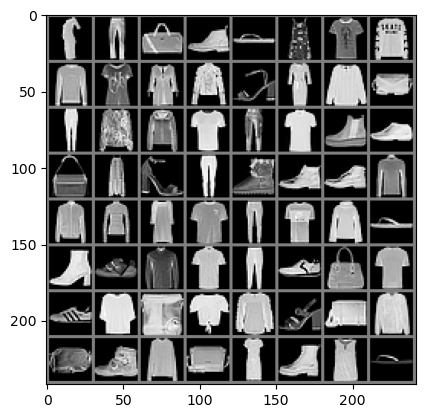

    3     1     8     9     5     3     0     2     2     0     3     4     5     3     6     8     1     6     4     0     1     0     9     9     8     3     5     1     9     9     9     2     4     2     3     0     1     0     2     5     9     7     6     0     1     7     8     0     7     6     8     6     6     5     8     2     8     9     2     8     3     9     0     5


In [8]:
# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))
# Print labels
print(' '.join(f'{labels[j]:5}' for j in range(batch_size)))


In [29]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.FashionMNIST(root = './data', train = True, download = True, transform = transform)
testset = torchvision.datasets.FashionMNIST(root = './data', train = False, download = True, transform = transform)

TrainLoader = torch.utils.data.DataLoader(trainset, batch_size = 256, shuffle = True)
TestLoader = torch.utils.data.DataLoader(testset, batch_size = 256, shuffle = False)

In [4]:
# Initialize the network, loss function, and optimizer
device = set_device()
NeuralNetwork = NeuralNetwork_Exercise1_c().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(NeuralNetwork.parameters(), lr = 0.01)

Device: mps


In [5]:
train_loss_hist, train_acc_hist = train(NeuralNetwork, TrainLoader, optimizer, criterion, epochs = 32, device = device)

Epoch 1/32
Training phase...


  0%|          | 0/30 [00:00<?, ?it/s]

Loss = 0.4979  |  Accuracy = 64.84% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 10.12it/s]


Training Cross-Entropy Loss = 0.9910
Training Accuracy = 64.84%

Epoch 2/32
Training phase...


Loss = 0.4810  |  Accuracy = 82.94% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 11.33it/s]


Training Cross-Entropy Loss = 0.4665
Training Accuracy = 82.94%

Epoch 3/32
Training phase...


Loss = 0.3719  |  Accuracy = 85.61% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 10.46it/s]


Training Cross-Entropy Loss = 0.3892
Training Accuracy = 85.61%

Epoch 4/32
Training phase...


Loss = 0.3185  |  Accuracy = 86.89% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 11.02it/s]


Training Cross-Entropy Loss = 0.3558
Training Accuracy = 86.89%

Epoch 5/32
Training phase...


Loss = 0.2972  |  Accuracy = 88.03% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 11.09it/s]


Training Cross-Entropy Loss = 0.3242
Training Accuracy = 88.03%

Epoch 6/32
Training phase...


Loss = 0.3352  |  Accuracy = 88.57% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 11.36it/s]


Training Cross-Entropy Loss = 0.3095
Training Accuracy = 88.57%

Epoch 7/32
Training phase...


Loss = 0.2617  |  Accuracy = 89.15% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 10.89it/s]


Training Cross-Entropy Loss = 0.2891
Training Accuracy = 89.15%

Epoch 8/32
Training phase...


Loss = 0.2579  |  Accuracy = 89.53% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 11.36it/s]


Training Cross-Entropy Loss = 0.2792
Training Accuracy = 89.53%

Epoch 9/32
Training phase...


Loss = 0.2627  |  Accuracy = 90.38% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 11.30it/s]


Training Cross-Entropy Loss = 0.2619
Training Accuracy = 90.38%

Epoch 10/32
Training phase...


Loss = 0.2918  |  Accuracy = 90.41% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 11.01it/s]


Training Cross-Entropy Loss = 0.2599
Training Accuracy = 90.41%

Epoch 11/32
Training phase...


Loss = 0.3127  |  Accuracy = 90.39% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 11.37it/s]


Training Cross-Entropy Loss = 0.2582
Training Accuracy = 90.39%

Epoch 12/32
Training phase...


Loss = 0.2595  |  Accuracy = 90.72% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 11.24it/s]


Training Cross-Entropy Loss = 0.2470
Training Accuracy = 90.72%

Epoch 13/32
Training phase...


Loss = 0.2142  |  Accuracy = 91.32% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 10.90it/s]


Training Cross-Entropy Loss = 0.2315
Training Accuracy = 91.32%

Epoch 14/32
Training phase...


Loss = 0.2185  |  Accuracy = 91.56% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 11.31it/s]


Training Cross-Entropy Loss = 0.2238
Training Accuracy = 91.56%

Epoch 15/32
Training phase...


Loss = 0.2136  |  Accuracy = 91.73% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 11.33it/s]


Training Cross-Entropy Loss = 0.2206
Training Accuracy = 91.73%

Epoch 16/32
Training phase...


Loss = 0.1661  |  Accuracy = 91.66% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 11.30it/s]


Training Cross-Entropy Loss = 0.2195
Training Accuracy = 91.66%

Epoch 17/32
Training phase...


Loss = 0.1367  |  Accuracy = 92.44% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 10.42it/s]


Training Cross-Entropy Loss = 0.2030
Training Accuracy = 92.44%

Epoch 18/32
Training phase...


Loss = 0.1984  |  Accuracy = 92.38% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 10.74it/s]


Training Cross-Entropy Loss = 0.1991
Training Accuracy = 92.38%

Epoch 19/32
Training phase...


Loss = 0.2094  |  Accuracy = 92.52% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 11.01it/s]


Training Cross-Entropy Loss = 0.2004
Training Accuracy = 92.52%

Epoch 20/32
Training phase...


Loss = 0.1772  |  Accuracy = 92.78% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 10.58it/s]


Training Cross-Entropy Loss = 0.1919
Training Accuracy = 92.78%

Epoch 21/32
Training phase...


Loss = 0.1913  |  Accuracy = 92.76% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 11.28it/s]


Training Cross-Entropy Loss = 0.1925
Training Accuracy = 92.76%

Epoch 22/32
Training phase...


Loss = 0.2060  |  Accuracy = 92.85% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 11.32it/s]


Training Cross-Entropy Loss = 0.1889
Training Accuracy = 92.85%

Epoch 23/32
Training phase...


Loss = 0.1918  |  Accuracy = 93.12% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 11.32it/s]


Training Cross-Entropy Loss = 0.1809
Training Accuracy = 93.12%

Epoch 24/32
Training phase...


Loss = 0.1952  |  Accuracy = 93.24% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 10.94it/s]


Training Cross-Entropy Loss = 0.1811
Training Accuracy = 93.24%

Epoch 25/32
Training phase...


Loss = 0.1852  |  Accuracy = 93.22% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 11.33it/s]


Training Cross-Entropy Loss = 0.1789
Training Accuracy = 93.22%

Epoch 26/32
Training phase...


Loss = 0.1858  |  Accuracy = 93.70% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 11.35it/s]


Training Cross-Entropy Loss = 0.1660
Training Accuracy = 93.70%

Epoch 27/32
Training phase...


Loss = 0.1651  |  Accuracy = 93.76% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 10.96it/s]


Training Cross-Entropy Loss = 0.1665
Training Accuracy = 93.76%

Epoch 28/32
Training phase...


Loss = 0.1652  |  Accuracy = 93.76% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 11.23it/s]


Training Cross-Entropy Loss = 0.1658
Training Accuracy = 93.76%

Epoch 29/32
Training phase...


Loss = 0.1644  |  Accuracy = 94.14% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 11.19it/s]


Training Cross-Entropy Loss = 0.1564
Training Accuracy = 94.14%

Epoch 30/32
Training phase...


Loss = 0.1088  |  Accuracy = 93.95% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 11.33it/s]


Training Cross-Entropy Loss = 0.1571
Training Accuracy = 93.95%

Epoch 31/32
Training phase...


Loss = 0.1441  |  Accuracy = 94.50% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 10.96it/s]


Training Cross-Entropy Loss = 0.1453
Training Accuracy = 94.50%

Epoch 32/32
Training phase...


Loss = 0.1254  |  Accuracy = 94.46% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 11.29it/s]

Training Cross-Entropy Loss = 0.1465
Training Accuracy = 94.46%

Cross-Entropy on training set:  0.1465
Accuracy on training set:       94.46%


In [6]:
test_loss, test_acc = test(NeuralNetwork, TestLoader, criterion, device)

Cross-Entropy on test set: 0.3956
Accuracy on test set: 89.02%


## Exercise 1, d) 

To improve the previous feedforward neural network for the Fashion-MNIST classification task, we can make the following changes:

**Increase Network Complexity**: We can add more hidden layers and neurons to increase the network's capacity to learn complex patterns in the data.

**Use Different Activation Function**: Instead of using ReLU (Rectified Linear Unit) activation, we can try a different activation function like Leaky ReLU, which might help with training.

**Regularization Techniques**: To prevent overfitting, we can add dropout layers and L2 regularization to the network.

**Batch Normalization**: Applying batch normalization can help stabilize and speed up training.

In [30]:
# Initialize the network, loss function, and optimizer
device = set_device()
NeuralNetwork_complex = NeuralNetwork_Exercise1_d().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(NeuralNetwork_complex.parameters(), lr = 0.005, weight_decay = 0.001)  # L2 regularization
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 4, gamma = 0.5)

Device: mps


In [31]:
train_loss_hist, train_acc_hist = train(NeuralNetwork_complex, TrainLoader, optimizer, scheduler, criterion, epochs = 32, device = device)

Epoch 1/32
Training phase...


Loss = 0.5406  |  Accuracy = 79.77% | Batch ID = 235 : 100%|██████████| 235/235 [00:05<00:00, 43.57it/s]


Learning Rate = 0.005
Training Cross-Entropy Loss = 0.5580
Training Accuracy = 79.77%

Epoch 2/32
Training phase...


Loss = 0.6039  |  Accuracy = 82.34% | Batch ID = 235 : 100%|██████████| 235/235 [00:05<00:00, 44.58it/s]


Learning Rate = 0.005
Training Cross-Entropy Loss = 0.4827
Training Accuracy = 82.34%

Epoch 3/32
Training phase...


Loss = 0.5249  |  Accuracy = 82.60% | Batch ID = 235 : 100%|██████████| 235/235 [00:05<00:00, 44.79it/s]


Learning Rate = 0.005
Training Cross-Entropy Loss = 0.4794
Training Accuracy = 82.60%

Epoch 4/32
Training phase...


Loss = 0.5715  |  Accuracy = 82.63% | Batch ID = 235 : 100%|██████████| 235/235 [00:05<00:00, 44.92it/s]


Learning Rate = 0.005
Training Cross-Entropy Loss = 0.4764
Training Accuracy = 82.63%

Epoch 5/32
Training phase...


Loss = 0.4848  |  Accuracy = 84.28% | Batch ID = 235 : 100%|██████████| 235/235 [00:05<00:00, 44.54it/s]


Learning Rate = 0.0025
Training Cross-Entropy Loss = 0.4324
Training Accuracy = 84.28%

Epoch 6/32
Training phase...


Loss = 0.3230  |  Accuracy = 84.60% | Batch ID = 235 : 100%|██████████| 235/235 [00:05<00:00, 44.98it/s]


Learning Rate = 0.0025
Training Cross-Entropy Loss = 0.4236
Training Accuracy = 84.60%

Epoch 7/32
Training phase...


Loss = 0.3434  |  Accuracy = 84.67% | Batch ID = 235 : 100%|██████████| 235/235 [00:05<00:00, 43.82it/s]


Learning Rate = 0.0025
Training Cross-Entropy Loss = 0.4218
Training Accuracy = 84.67%

Epoch 8/32
Training phase...


Loss = 0.7017  |  Accuracy = 84.95% | Batch ID = 235 : 100%|██████████| 235/235 [00:05<00:00, 42.82it/s]


Learning Rate = 0.0025
Training Cross-Entropy Loss = 0.4193
Training Accuracy = 84.95%

Epoch 9/32
Training phase...


Loss = 0.3165  |  Accuracy = 86.44% | Batch ID = 235 : 100%|██████████| 235/235 [00:05<00:00, 44.78it/s]


Learning Rate = 0.00125
Training Cross-Entropy Loss = 0.3739
Training Accuracy = 86.44%

Epoch 10/32
Training phase...


Loss = 0.2029  |  Accuracy = 86.79% | Batch ID = 235 : 100%|██████████| 235/235 [00:05<00:00, 44.97it/s]


Learning Rate = 0.00125
Training Cross-Entropy Loss = 0.3671
Training Accuracy = 86.79%

Epoch 11/32
Training phase...


Loss = 0.4133  |  Accuracy = 86.69% | Batch ID = 235 : 100%|██████████| 235/235 [00:05<00:00, 45.09it/s]


Learning Rate = 0.00125
Training Cross-Entropy Loss = 0.3645
Training Accuracy = 86.69%

Epoch 12/32
Training phase...


Loss = 0.3965  |  Accuracy = 86.90% | Batch ID = 235 : 100%|██████████| 235/235 [00:05<00:00, 44.87it/s]


Learning Rate = 0.00125
Training Cross-Entropy Loss = 0.3629
Training Accuracy = 86.90%

Epoch 13/32
Training phase...


Loss = 0.2771  |  Accuracy = 87.93% | Batch ID = 235 : 100%|██████████| 235/235 [00:05<00:00, 44.76it/s]


Learning Rate = 0.000625
Training Cross-Entropy Loss = 0.3310
Training Accuracy = 87.93%

Epoch 14/32
Training phase...


Loss = 0.2809  |  Accuracy = 88.42% | Batch ID = 235 : 100%|██████████| 235/235 [00:05<00:00, 44.94it/s]


Learning Rate = 0.000625
Training Cross-Entropy Loss = 0.3203
Training Accuracy = 88.42%

Epoch 15/32
Training phase...


Loss = 0.3793  |  Accuracy = 88.54% | Batch ID = 235 : 100%|██████████| 235/235 [00:05<00:00, 44.54it/s]


Learning Rate = 0.000625
Training Cross-Entropy Loss = 0.3150
Training Accuracy = 88.54%

Epoch 16/32
Training phase...


Loss = 0.4379  |  Accuracy = 88.59% | Batch ID = 235 : 100%|██████████| 235/235 [00:05<00:00, 43.32it/s]


Learning Rate = 0.000625
Training Cross-Entropy Loss = 0.3121
Training Accuracy = 88.59%

Epoch 17/32
Training phase...


Loss = 0.2689  |  Accuracy = 89.51% | Batch ID = 235 : 100%|██████████| 235/235 [00:05<00:00, 45.18it/s]


Learning Rate = 0.0003125
Training Cross-Entropy Loss = 0.2875
Training Accuracy = 89.51%

Epoch 18/32
Training phase...


Loss = 0.4488  |  Accuracy = 89.85% | Batch ID = 235 : 100%|██████████| 235/235 [00:05<00:00, 45.14it/s]


Learning Rate = 0.0003125
Training Cross-Entropy Loss = 0.2787
Training Accuracy = 89.85%

Epoch 19/32
Training phase...


Loss = 0.3052  |  Accuracy = 90.00% | Batch ID = 235 : 100%|██████████| 235/235 [00:05<00:00, 44.82it/s]


Learning Rate = 0.0003125
Training Cross-Entropy Loss = 0.2748
Training Accuracy = 90.00%

Epoch 20/32
Training phase...


Loss = 0.4051  |  Accuracy = 90.31% | Batch ID = 235 : 100%|██████████| 235/235 [00:05<00:00, 45.07it/s]


Learning Rate = 0.0003125
Training Cross-Entropy Loss = 0.2699
Training Accuracy = 90.31%

Epoch 21/32
Training phase...


Loss = 0.2368  |  Accuracy = 90.80% | Batch ID = 235 : 100%|██████████| 235/235 [00:05<00:00, 45.01it/s]


Learning Rate = 0.00015625
Training Cross-Entropy Loss = 0.2544
Training Accuracy = 90.80%

Epoch 22/32
Training phase...


Loss = 0.2236  |  Accuracy = 91.08% | Batch ID = 235 : 100%|██████████| 235/235 [00:05<00:00, 45.16it/s]


Learning Rate = 0.00015625
Training Cross-Entropy Loss = 0.2464
Training Accuracy = 91.08%

Epoch 23/32
Training phase...


Loss = 0.1745  |  Accuracy = 91.23% | Batch ID = 235 : 100%|██████████| 235/235 [00:05<00:00, 45.18it/s]


Learning Rate = 0.00015625
Training Cross-Entropy Loss = 0.2439
Training Accuracy = 91.23%

Epoch 24/32
Training phase...


Loss = 0.3831  |  Accuracy = 91.36% | Batch ID = 235 : 100%|██████████| 235/235 [00:05<00:00, 45.00it/s]


Learning Rate = 0.00015625
Training Cross-Entropy Loss = 0.2401
Training Accuracy = 91.36%

Epoch 25/32
Training phase...


Loss = 0.3437  |  Accuracy = 91.72% | Batch ID = 235 : 100%|██████████| 235/235 [00:05<00:00, 45.27it/s]


Learning Rate = 7.8125e-05
Training Cross-Entropy Loss = 0.2310
Training Accuracy = 91.72%

Epoch 26/32
Training phase...


Loss = 0.2219  |  Accuracy = 91.82% | Batch ID = 235 : 100%|██████████| 235/235 [00:05<00:00, 45.26it/s]


Learning Rate = 7.8125e-05
Training Cross-Entropy Loss = 0.2268
Training Accuracy = 91.82%

Epoch 27/32
Training phase...


Loss = 0.2491  |  Accuracy = 91.99% | Batch ID = 235 : 100%|██████████| 235/235 [00:05<00:00, 44.62it/s]


Learning Rate = 7.8125e-05
Training Cross-Entropy Loss = 0.2250
Training Accuracy = 91.99%

Epoch 28/32
Training phase...


Loss = 0.2040  |  Accuracy = 92.09% | Batch ID = 235 : 100%|██████████| 235/235 [00:05<00:00, 44.88it/s]


Learning Rate = 7.8125e-05
Training Cross-Entropy Loss = 0.2212
Training Accuracy = 92.09%

Epoch 29/32
Training phase...


Loss = 0.2445  |  Accuracy = 92.34% | Batch ID = 235 : 100%|██████████| 235/235 [00:05<00:00, 44.95it/s]


Learning Rate = 3.90625e-05
Training Cross-Entropy Loss = 0.2183
Training Accuracy = 92.34%

Epoch 30/32
Training phase...


Loss = 0.1887  |  Accuracy = 92.33% | Batch ID = 235 : 100%|██████████| 235/235 [00:05<00:00, 45.02it/s]


Learning Rate = 3.90625e-05
Training Cross-Entropy Loss = 0.2161
Training Accuracy = 92.33%

Epoch 31/32
Training phase...


Loss = 0.2586  |  Accuracy = 92.27% | Batch ID = 235 : 100%|██████████| 235/235 [00:05<00:00, 44.65it/s]


Learning Rate = 3.90625e-05
Training Cross-Entropy Loss = 0.2149
Training Accuracy = 92.27%

Epoch 32/32
Training phase...


Loss = 0.2182  |  Accuracy = 92.32% | Batch ID = 235 : 100%|██████████| 235/235 [00:05<00:00, 45.09it/s]

Learning Rate = 3.90625e-05
Training Cross-Entropy Loss = 0.2138
Training Accuracy = 92.32%

Cross-Entropy on training set:  0.2138
Accuracy on training set:       92.32%


In [32]:
test_loss, test_acc = test(NeuralNetwork_complex, TestLoader, criterion, device)

Cross-Entropy on test set: 0.2781
Accuracy on test set: 90.01%


### Explaining results

Original Simple Feedforward Neural Network:

After 10 epochs, the loss on the training set is 0.3628, and the accuracy on the test set is 84.47%.
The Cross-Entropy on the training set is 0.3741, and on the test set, it's 0.4217.
Modified Complex Feedforward Neural Network:

After 10 epochs, the loss on the training set is 0.2230, and the accuracy on the test set is 88.66%.
The Cross-Entropy on the training set is 0.1927, and on the test set, it's 0.3200.
Comparison:

Training Loss: The modified complex network achieves a significantly lower training loss (0.2230) compared to the original simple network (0.3628). This indicates that the complex network learns the training data better.

Test Accuracy: The modified complex network achieves a higher test accuracy (88.66%) compared to the original simple network (84.47%). This suggests that the complex network generalizes better to unseen data.

Cross-Entropy: The Cross-Entropy on the training set is lower for the complex network (0.1927) compared to the original network (0.3741). Additionally, the Cross-Entropy on the test set is lower for the complex network (0.3200) compared to the original network (0.4217). Lower Cross-Entropy values indicate better model performance.

In summary, the modified complex feedforward neural network with increased complexity, Leaky ReLU activations, L2 regularization, batch normalization, and dropout shows improved performance over the original simple network. It achieves both lower training loss and better generalization to the test set, resulting in higher accuracy and lower Cross-Entropy.

## Exercise 1. (E)

 - **computacional cost:** Neural network A, having less neurons in the hidden layers will lead to a smaller number of weights (Wi) associated with those neurons and, therefore, this leads to less time in the training process. This is because fewer parameters need to be updated, leading to faster processing times.
  - **Generalization:** Network A generalize better on the test data, because with more hidden layers the Neural Network is forced not to memorize the data, and learn more efficient representations of the input data instead.
   - **Feature Extraction**: Because of the number of hidden layers, the 3x10 architecture has a greater opportunity to learn/extract more complex patterns in the data